# Imports

In [1]:
import numpy as np
import random
import os
import cv2
import tarfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Activation, Input, Conv2D, BatchNormalization, Conv2DTranspose,
                                     concatenate, MaxPool2D, Concatenate, Rescaling)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, jaccard_score

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data Downloading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = "/content/drive/MyDrive/LaPa.tar.gz"
extracted_dir = '/content/LaPa'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(extracted_dir)

In [4]:
image = cv2.imread("/content/LaPa/LaPa/train/images/10001436895_0.jpg")
height, width, channels = image.shape
print("Shape: Height={}, Width={}, Channels={}".format(height, width, channels))

mask = cv2.imread("/content/LaPa/LaPa/train/labels/10001436895_0.png")
height, width, channels = mask.shape
print("Shape: Height={}, Width={}, Channels={}".format(height, width, channels))

Shape: Height=492, Width=440, Channels=3
Shape: Height=492, Width=440, Channels=3


In [5]:
rgb_codes = [[0, 0, 0], [0, 153, 255], [102, 255, 153], [0, 204, 153],
             [255, 255, 102], [255, 255, 204], [255, 153, 0], [255, 102, 255],
             [102, 0, 51], [255, 204, 255], [255, 0, 102]]

classes = ["background", "skin", "left eyebrow", "right eyebrow",
           "left eye", "right eye", "nose", "upper lip", "inner mouth",
           "lower lip", "hair"]

num_classes = len(classes)

In [ ]:
train_images = "/content/LaPa/LaPa/train/images"
train_masks = "/content/LaPa/LaPa/train/labels"
test_images = "/content/LaPa/LaPa/test/images"
test_masks = "/content/LaPa/LaPa/test/labels"

train_images_paths = sorted([
    os.path.join(train_images, fname)
    for fname in os.listdir(train_images)
])

train_mask_paths = sorted([
    os.path.join(train_masks, fname)
    for fname in os.listdir(train_masks)
])

test_images_paths = sorted([
    os.path.join(test_images, fname)
    for fname in os.listdir(test_images)
])

test_mask_paths = sorted([
    os.path.join(test_masks, fname)
    for fname in os.listdir(test_masks)
])

print("Number of train images:", len(train_images_paths))
print("Number of train masks:", len(train_mask_paths))
print("Images:", train_images_paths[0:5], "|", "Mask:", train_mask_paths[0:5])
print("*********************************************************************")
print("Number of test images:", len(test_images_paths))
print("Number of test masks:", len(test_mask_paths))
print("Images:", test_images_paths[0:5], "|", "Mask:", test_mask_paths[0:5])

Number of train images: 18168
Number of train masks: 18168
Images: ['/content/LaPa/LaPa/train/images/10001436895_0.jpg', '/content/LaPa/LaPa/train/images/10003645676_0.jpg', '/content/LaPa/LaPa/train/images/10004446093_1.jpg', '/content/LaPa/LaPa/train/images/10004446093_17.jpg', '/content/LaPa/LaPa/train/images/10004446093_2.jpg'] | Mask: ['/content/LaPa/LaPa/train/labels/10001436895_0.png', '/content/LaPa/LaPa/train/labels/10003645676_0.png', '/content/LaPa/LaPa/train/labels/10004446093_1.png', '/content/LaPa/LaPa/train/labels/10004446093_17.png', '/content/LaPa/LaPa/train/labels/10004446093_2.png']
*********************************************************************
Number of test images: 2000
Number of test masks: 2000
Images: ['/content/LaPa/LaPa/test/images/10001868414_0.jpg', '/content/LaPa/LaPa/test/images/10009865324_0.jpg', '/content/LaPa/LaPa/test/images/10012551673_5.jpg', '/content/LaPa/LaPa/test/images/10012551673_8.jpg', '/content/LaPa/LaPa/test/images/10014368575_1.jpg

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_paths, train_mask_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_paths, test_mask_paths))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [ ]:
IMG_SIZE = 128
MASK_SIZE = 128

def get_images(image_path, mask_path):
  image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
  image = tf.cast(tf.image.resize(image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)

  mask = tf.io.decode_png(tf.io.read_file(mask_path), channels=1)
  mask = tf.cast(tf.image.resize(mask, [MASK_SIZE, MASK_SIZE]), dtype=tf.int32)

  return image, mask

In [ ]:
train_dataset = train_dataset.map(get_images)
test_dataset = test_dataset.map(get_images)

# Data Visulization

In [ ]:
def plot_images(image, mask):
  fig, arr = plt.subplots(1, 3, figsize=(20, 8))
  arr[0].imshow(image/255)
  arr[0].set_title('Image')
  arr[0].axis('off')
  arr[1].imshow(mask)
  arr[1].set_title('Segementation')
  arr[1].axis('off')
  arr[2].imshow(mask, cmap='Paired')
  arr[2].set_title('Image Overlay')
  arr[2].axis('off');

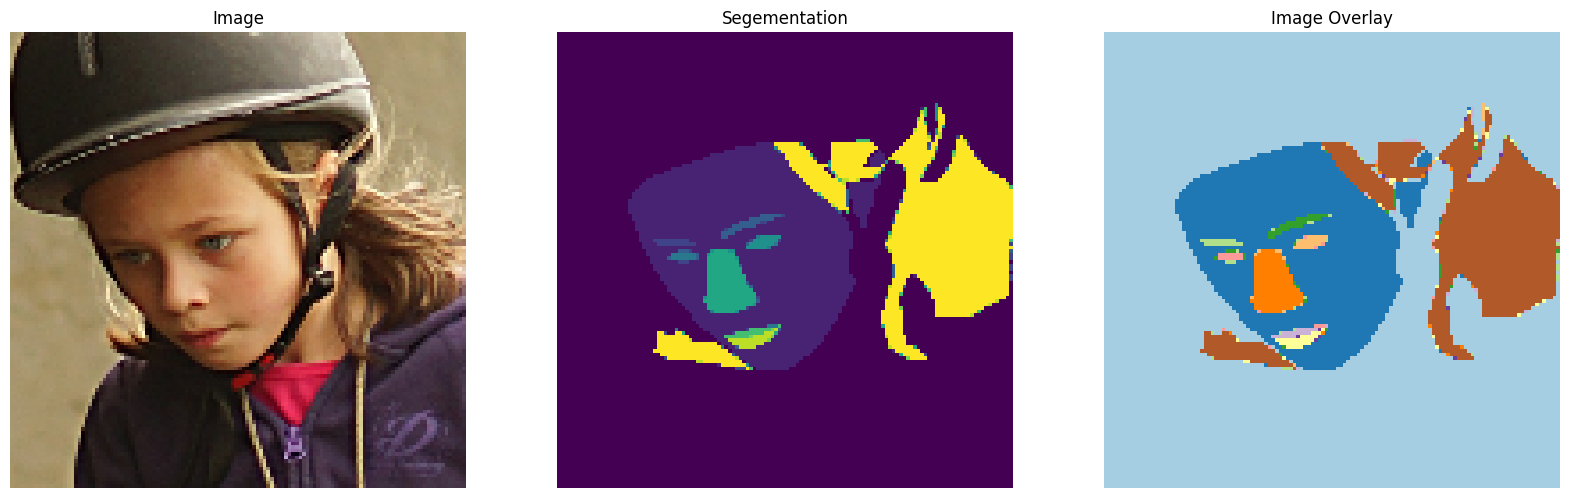

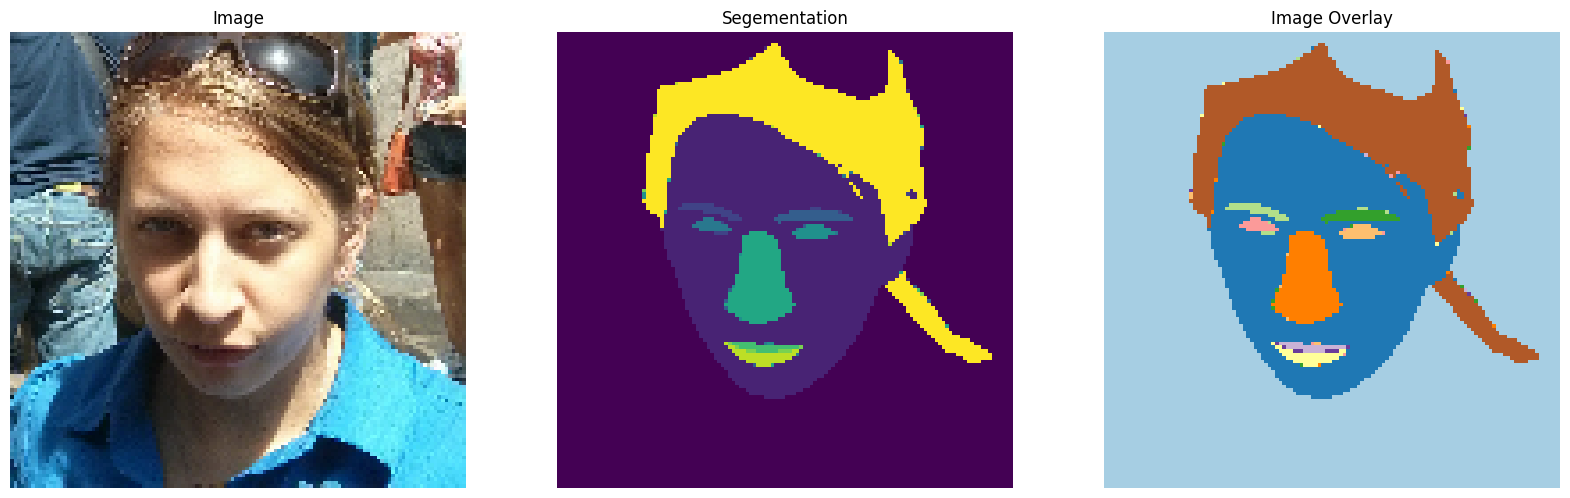

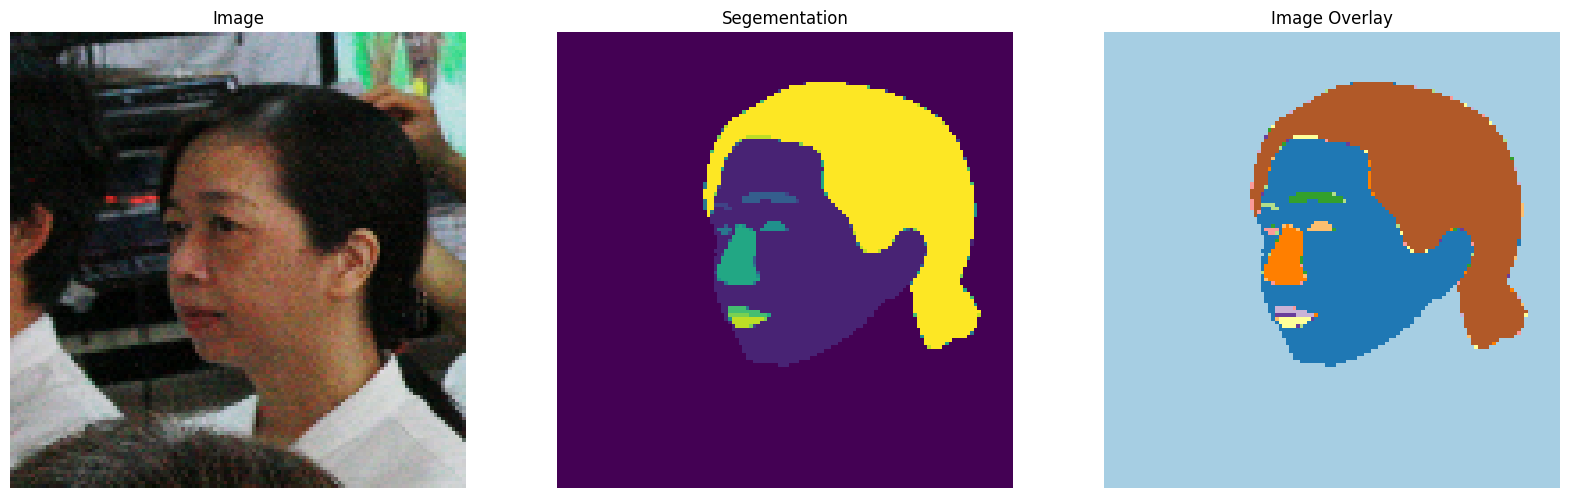

In [ ]:
for image, mask in train_dataset.take(3):
  plot_images(image, mask)

# Data Augumentation

In [ ]:
import albumentations as A

transforms = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.RandomRotate90(p=1),
    A.Transpose(p=1)
])

In [ ]:
def aug_albument(image, mask):
  augmented = transforms(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented['image'], dtype=tf.float32),
          tf.convert_to_tensor(augmented['mask'], dtype=tf.float32)]

In [ ]:
def process_data(image, mask):
  augmented = tf.numpy_function(func=aug_albument, inp=[image, mask], Tout=(tf.float32, tf.float32))
  return augmented[0], augmented[1]

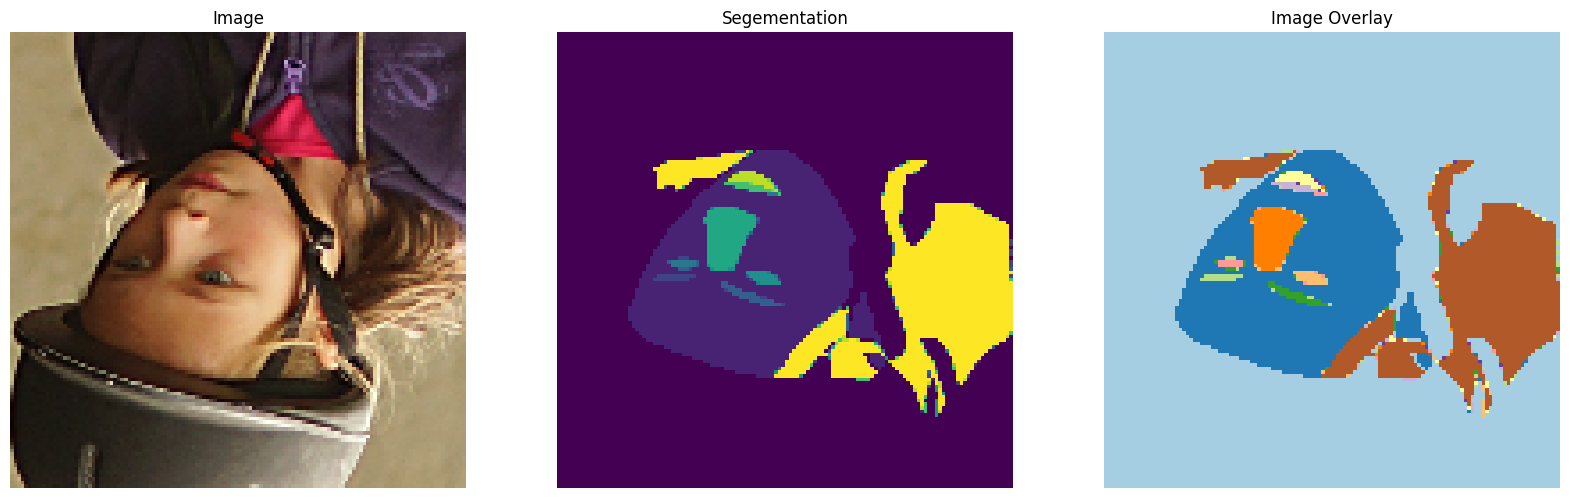

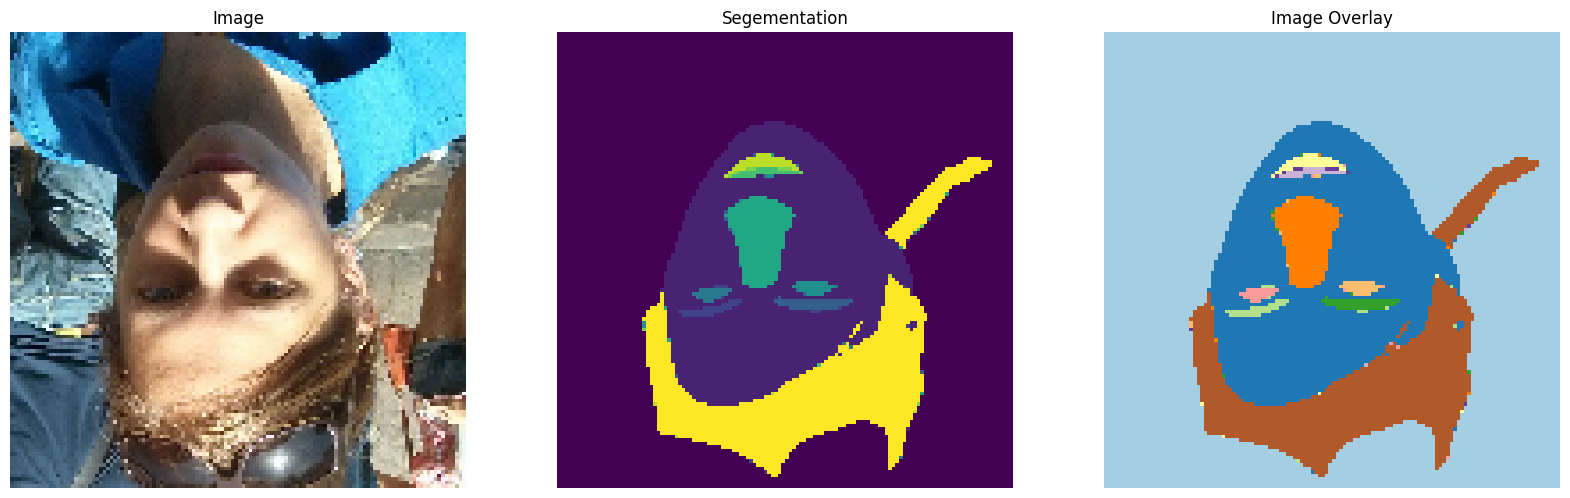

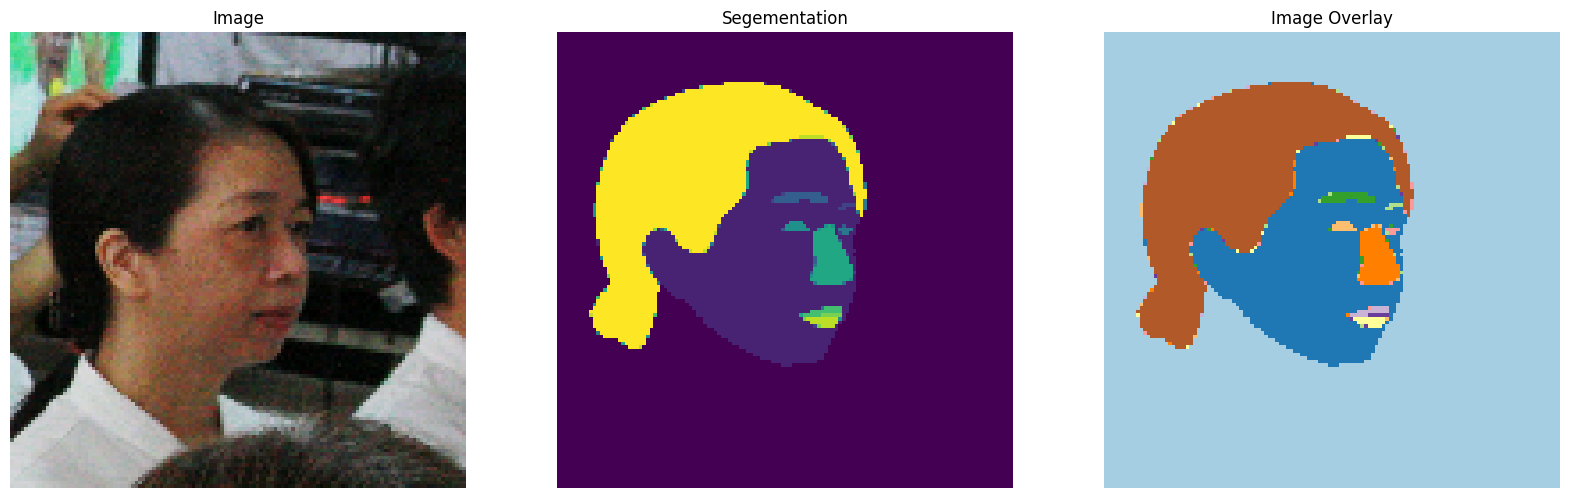

In [ ]:
for image, mask in train_dataset.take(3):
  aug_image, aug_mask = process_data(image, mask)
  plot_images(aug_image, aug_mask)

# Data Loading

In [ ]:
BATCH_SIZE = 64

In [ ]:
def process_mask(image, mask):
  mask = tf.one_hot(mask, num_classes)
  mask = tf.cast(tf.reshape(mask, [MASK_SIZE, MASK_SIZE, num_classes]), dtype=tf.int32)
  return image, mask

In [ ]:
train_dataset = (
    train_dataset
    .map(process_mask)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:

test_dataset = (
    test_dataset
    .map(process_mask)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for image, mask in train_dataset.take(1):
  print(image.shape)
  print(mask.shape)

(64, 128, 128, 3)
(64, 128, 128, 11)


# Unet Model

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

In [ ]:
input_layer = Input(shape=(128, 128, 3))
rescale_layer = Rescaling(scale=1./255)(input_layer)

s1, p1 = encoder_block(rescale_layer, 64)
s2, p2 = encoder_block(p1, 128)
s3, p3 = encoder_block(p2, 256)
s4, p4 = encoder_block(p3, 512)

b1 = conv_block(p4, 1024)

d1 = decoder_block(b1, s4, 512)
d2 = decoder_block(d1, s3, 256)
d3 = decoder_block(d2, s2, 128)
d4 = decoder_block(d3, s1, 64)

output_layer = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

model = Model(input_layer, output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                               

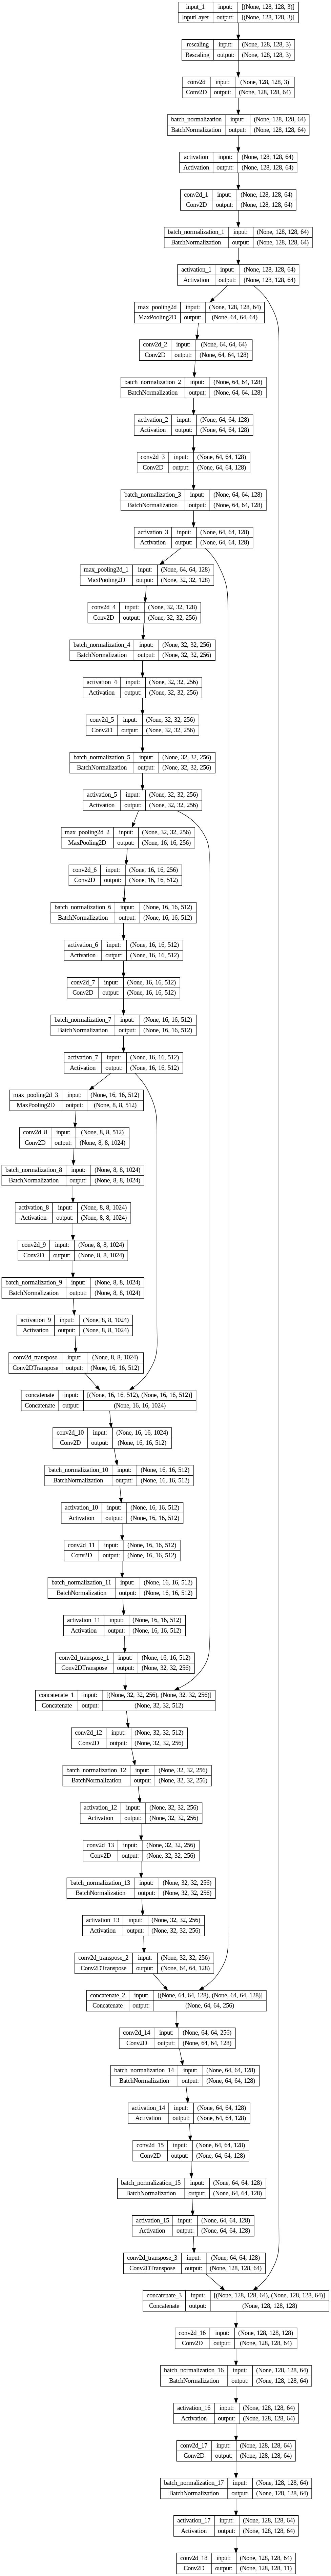

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy')

In [ ]:
os.mkdir("Generated")

In [ ]:
class ShowImage(Callback):
  def on_epoch_end(self, epoch, logs=None):
    for batch_image, batch_mask in test_dataset.take(1):
        i = 0
        pred = model.predict(tf.expand_dims(batch_image[i], axis=0))[0]
        pred = np.argmax(pred, axis=-1).astype(np.int32)
        mask = np.argmax(batch_mask[i], axis=-1).astype(np.int32)

        fig, arr = plt.subplots(1, 3, figsize=(20, 8))
        arr[0].imshow(batch_image[i] / 255)
        arr[0].set_title('Image')
        arr[0].axis('off')
        arr[1].imshow(mask)
        arr[1].set_title('Segmentation')
        arr[1].axis('off')
        arr[2].imshow(pred, cmap='Paired')
        arr[2].set_title('Predicted Segmentation')
        arr[2].axis('off')

        plt.tight_layout()
        plt.savefig("Generated/gen_images_epoch_{}.png".format(epoch + 1))
        plt.close(fig)

In [ ]:
history = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs=10,
                    callbacks=[ShowImage()])

Epoch 1/10
  6/284 [..............................] - ETA: 3:43 - loss: 1.7713

284/284 [==============================] - 294s 1s/step - loss: 0.4453 - val_loss: 1.3762
Epoch 2/10
284/284 [==============================] - 273s 959ms/step - loss: 0.2427 - val_loss: 0.7505
Epoch 3/10
284/284 [==============================] - 276s 972ms/step - loss: 0.1920 - val_loss: 0.5464
Epoch 4/10
284/284 [==============================] - 273s 961ms/step - loss: 0.1614 - val_loss: 0.3356
Epoch 5/10
284/284 [==============================] - 266s 936ms/step - loss: 0.1418 - val_loss: 0.2573
Epoch 6/10
284/284 [==============================] - 265s 933ms/step - loss: 0.1300 - val_loss: 0.2449
Epoch 7/10
284/284 [==============================] - 265s 931ms/step - loss: 0.1197 - val_loss: 0.2240
Epoch 8/10
284/284 [==============================] - 266s 935ms/step - loss: 0.1122 - val_loss: 0.2038
Epoch 9/10
284/284 [==============================] - 264s 930ms/step - loss: 0.1053 - val_loss: 0.2227
Epoch 10/10
284/284 [==============================] - 265s 933ms/step - loss:

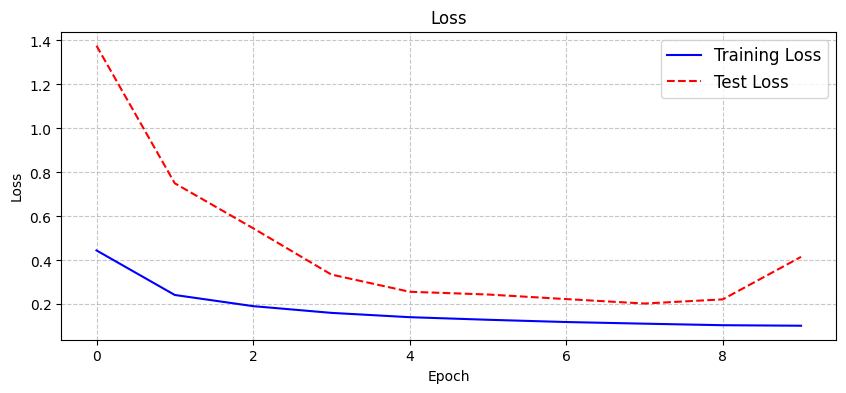

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history.history['loss'], label='Training Loss', linestyle='-', color='b')
plt.plot(history.history['val_loss'], label='Test Loss', linestyle='--', color='r')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

# Model Evaluation

In [ ]:
labels = [i for i in range(num_classes)]
SCORE = []

for batch_images, batch_mask in test_dataset:
    batch_pred = model.predict(batch_images)
    batch_pred = np.argmax(batch_pred, axis=-1)
    batch_pred = batch_pred.astype(np.int32)

    batch_mask = np.array(batch_mask)
    batch_mask = np.argmax(batch_mask, axis=-1)
    batch_mask = batch_mask.astype(np.int32)

    batch_mask = batch_mask.flatten()
    batch_pred = batch_pred.flatten()

    f1_value = f1_score(batch_mask, batch_pred, labels=labels, average=None, zero_division=0)
    jac_value = jaccard_score(batch_mask, batch_pred, labels=labels, average=None, zero_division=0)

    SCORE.append([f1_value, jac_value])

score = np.array(SCORE)
score = np.mean(score, axis=0)

1/1 [==============================] - 0s 22ms/step


In [ ]:
l = ["Class", "F1", "Jaccard"]
print(f"{l[0]:15s} {l[1]:10s} {l[2]:10s}")
print("-----------------------------------------------")

for i in range(num_classes):
  class_name = classes[i]
  f1 = score[0, i]
  jac = score[1, i]
  dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
  print(dstr)

print("-----------------------------------------------")
class_mean = np.mean(score, axis=-1)
class_name = "Mean"
f1 = class_mean[0]
jac = class_mean[1]
dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f}"
print(dstr)

Class           F1         Jaccard   
-----------------------------------------------
background     : 0.93227 - 0.87323
skin           : 0.83576 - 0.71842
left eyebrow   : 0.34901 - 0.21178
right eyebrow  : 0.36217 - 0.22176
left eye       : 0.41193 - 0.26011
right eye      : 0.36765 - 0.22568
nose           : 0.79663 - 0.66287
upper lip      : 0.39346 - 0.24569
inner mouth    : 0.47829 - 0.31540
lower lip      : 0.53616 - 0.36686
hair           : 0.80137 - 0.66942
-----------------------------------------------
Mean           : 0.56952 - 0.43375


# Model Predictions

In [ ]:
def plot_images(image, mask, pred_mask):
  fig, arr = plt.subplots(1, 3, figsize=(20, 8))
  arr[0].imshow(image/255)
  arr[0].set_title('Image')
  arr[0].axis('off')
  arr[1].imshow(mask)
  arr[1].set_title('Segementation')
  arr[1].axis('off')
  arr[2].imshow(pred_mask, cmap='Paired')
  arr[2].set_title('Predicted Segementation')
  arr[2].axis('off');

1/1 [==============================] - 0s 23ms/step


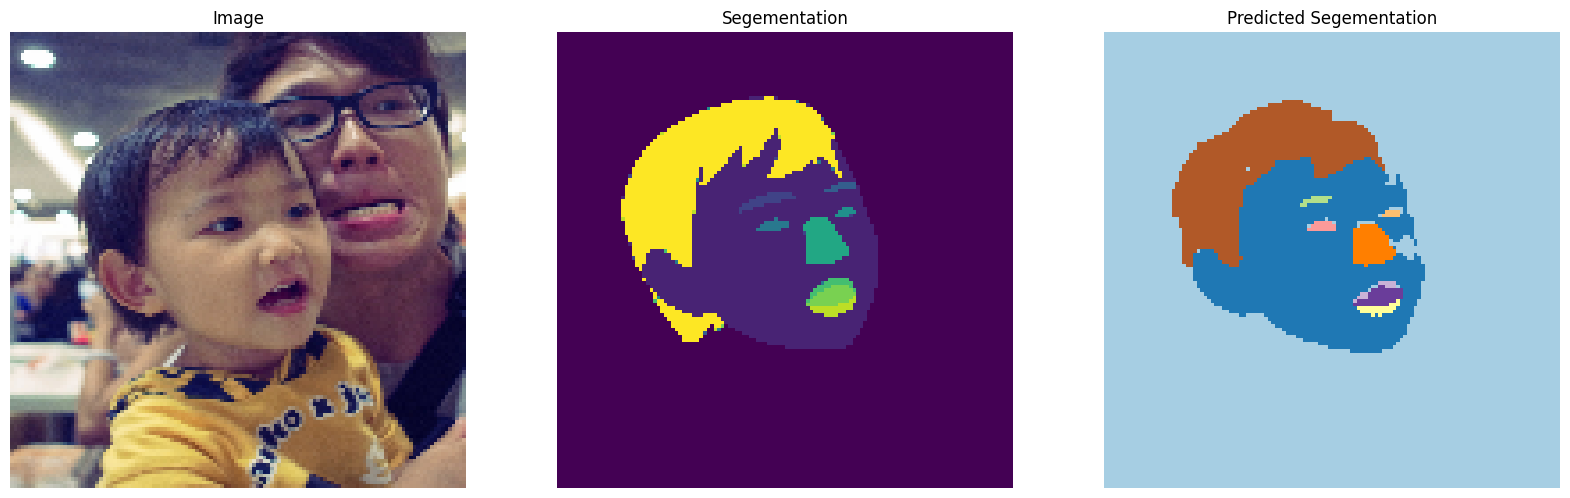

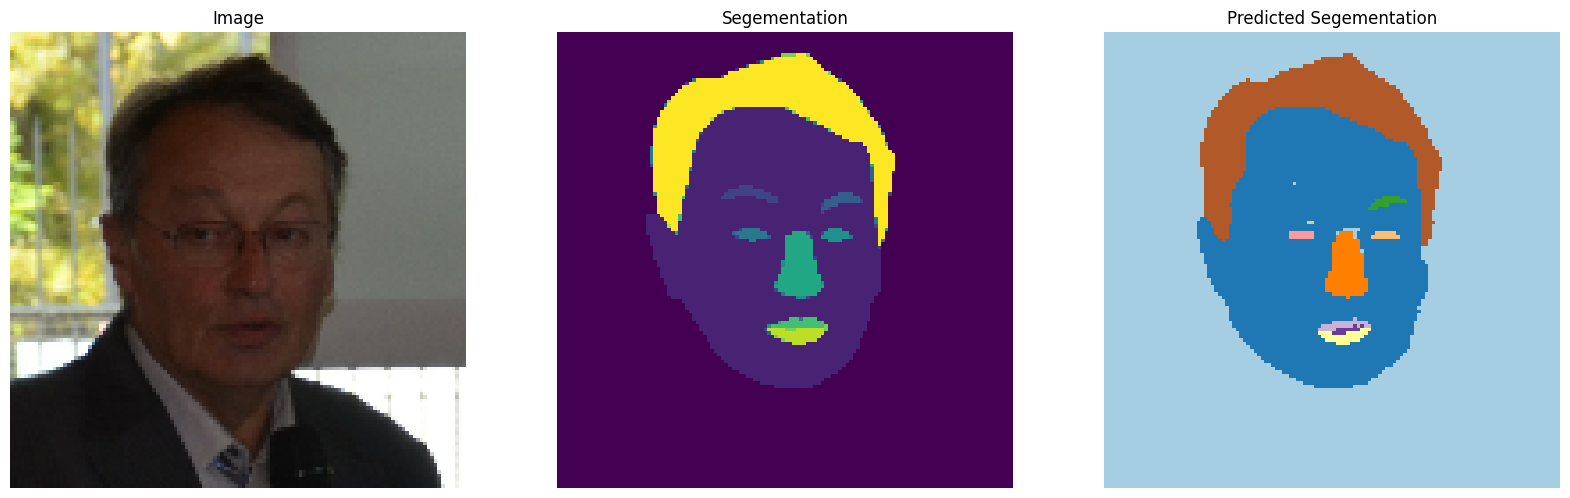

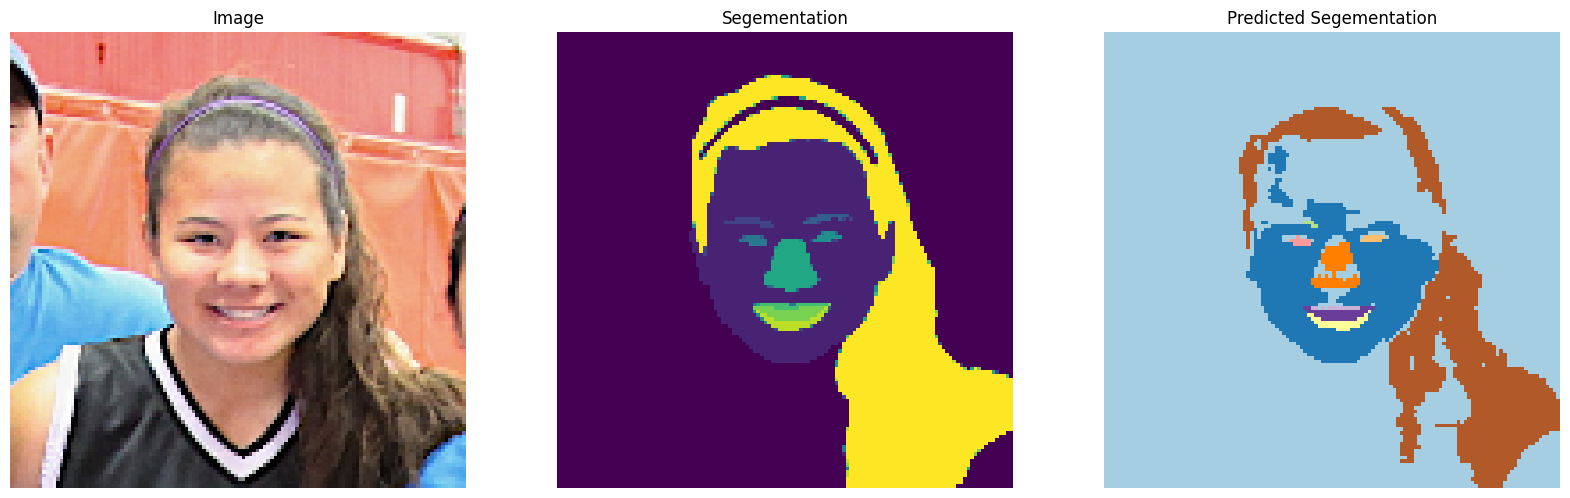

In [ ]:
for batch_image, batch_mask in test_dataset.take(1):
  for i in range(3):
    pred = model.predict(tf.expand_dims(batch_image[i], axis=0))[0]
    pred = np.argmax(pred, axis=-1)
    pred = pred.astype(np.int32)

    mask = np.array(batch_mask[i])
    mask = np.argmax(mask, axis=-1)
    mask = mask.astype(np.int32)

    plot_images(batch_image[i], mask, pred)

# Creating Gif

In [ ]:
from PIL import Image
import os

images_folder = "/content/Generated"
gif_filename = "Segementation_Images.gif"

images = []
for filename in sorted(os.listdir(images_folder)):
  if filename.endswith(".png"):
    filepath = os.path.join(images_folder, filename)
    img = Image.open(filepath)
    images.append(img)

images[0].save(gif_filename, save_all=True,
              append_images=images[1:],
              duration=50,
              loop=0)

# Saving Model

In [ ]:
model.save("Unet_Segementation_model")
loaded_model = tf.keras.models.load_model("Unet_Segementation_model")

In [6]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Unet_Segementation_model")

1/1 [==============================] - 0s 439ms/step


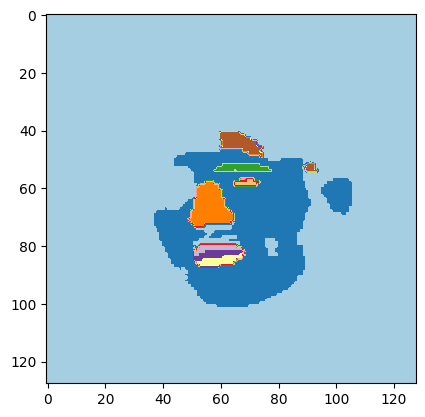

In [16]:
image_path ="//content/LaPa/LaPa/train/images/10288730973_2.jpg"
IMG_SIZE = 128
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)
pred = loaded_model.predict(tf.expand_dims(image, axis=0))[0]
pred = np.argmax(pred, axis=-1).astype(np.int32)
plt.imshow(pred, cmap='Paired')

# Hugging Face

In [8]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 3.7 MB/s eta 0:00:00


In [17]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model, repo_id = "DriveMyScream/Face_Image_Segementation")

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

keras_metadata.pb:   0%|          | 0.00/149k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/124M [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/Face_Image_Segementation/tree/main/'

In [18]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Face_Image_Segementation")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


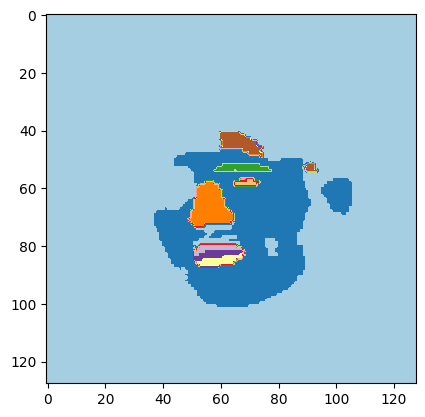

In [19]:
image_path = "/content/LaPa/LaPa/train/images/10288730973_2.jpg"
IMG_SIZE = 128
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)
pred = loaded_model.predict(tf.expand_dims(image, axis=0))[0]
pred = np.argmax(pred, axis=-1).astype(np.int32)
plt.imshow(pred, cmap='Paired')

# Tensorflow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Face_Image_Segementation.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

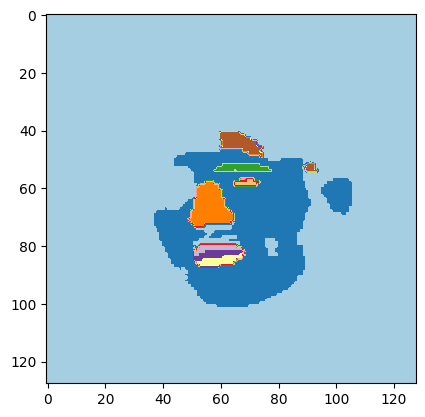

In [24]:
model_path = "/content/drive/MyDrive/Image_Segementation/Face_Image_Segementation.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = "/content/LaPa/LaPa/train/images/10288730973_2.jpg"
IMG_SIZE = 128

image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)
image_batch = tf.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], image_batch)
interpreter.invoke()
pred = interpreter.get_tensor(output_details[0]['index'])[0]
predicted_class_labels = np.argmax(pred, axis=-1).astype(np.uint8)

plt.imshow(predicted_class_labels, cmap='Paired')
plt.show()